# 1. Install Necessary Libraries

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_experimental matplotlib langgraph

# 2. Import necessary dependencies and set environment variables

In [2]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")



OPENAI_API_KEY: ··········
TAVILY_API_KEY: ··········


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

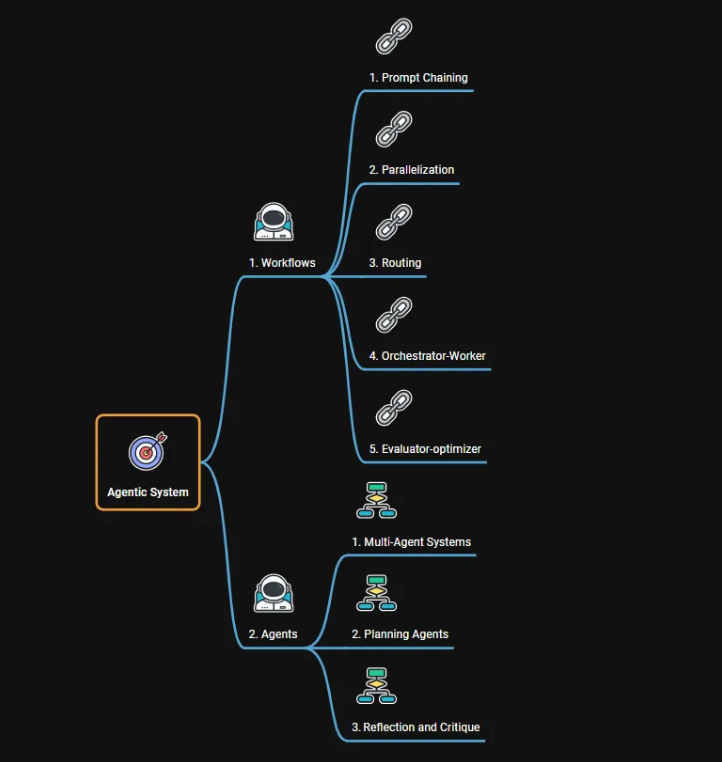

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Agents - Multiagent System (Hierarchical)

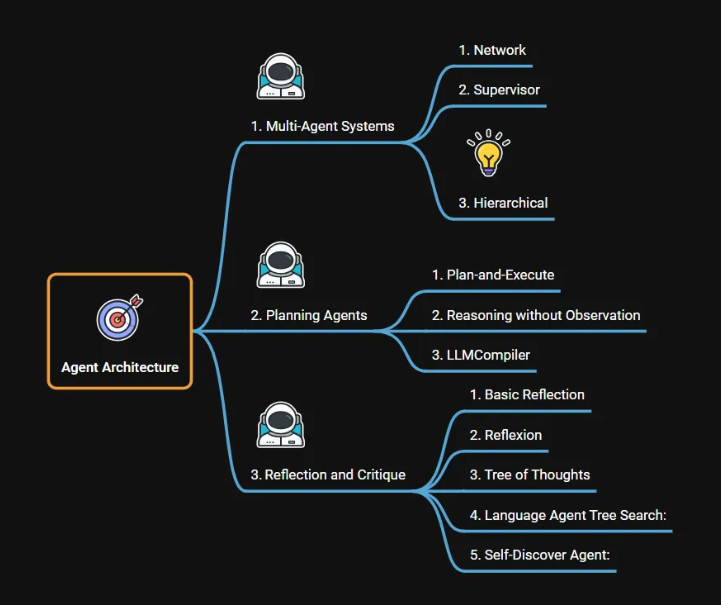

Detailed Blog : https://aiproductplaybook.substack.com/p/109-what-the-heck-are-hierarchical

### a. Create the Hierarchical Agents Team

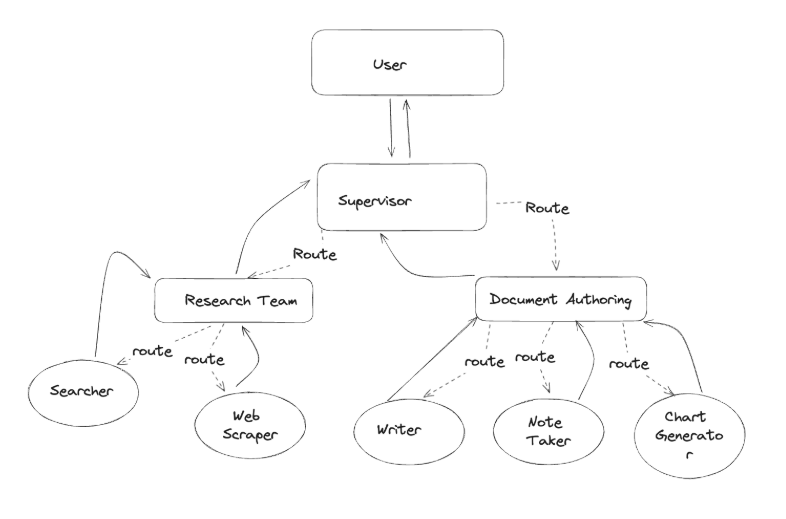


### b. Create tools for Research Team

1. Import necessary dependencies

2. Tavily Search Tool

a. Creates an instance of TavilySearchResults, likely for searching the web. max_results=5 limits the number of returned search results to 5

3. scrape_webpages Tool

a. This defines a function scrape_webpages and marks it as a tool using the @tool decorator. This means a language model can call this function.

b. urls: List[str]: Specifies that the function expects a list of strings as input, where each string is a URL.

c. -> str: Indicates that the function returns a string.

d. loader = WebBaseLoader(urls): Creates a WebBaseLoader instance to load the web pages specified by the urls list. This loader likely uses requests and BeautifulSoup4 under the hood (as suggested in the docstring) to fetch the web pages and parse their HTML content.

e. docs = loader.load(): Loads the content of the web pages. The load() method returns a list of Document objects.

f. The return statement constructs a single string containing the content of all scraped documents. It formats each document's content within XML-like tags: <Document name="...">\n...\n</Document>. The doc.metadata.get("title", "") part retrieves the title of the page from the metadata; if the title isn't available, it defaults to an empty string. The \n\n adds two newlines between each document's content in the final string.

In [3]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### c. Create tools for Document writing team

1. Import necessary dependencies

2. Global variables

a. _TEMP_DIRECTORY = TemporaryDirectory(): Creates a temporary directory. This directory will be used to store the files created and edited by the tools.

b. WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name): Defines the working directory as the path to the temporary directory.

3. Tools

The code defines several tools using the @tool decorator. Each tool is a function that a language model can call to perform a specific action.

a. create_outline(points: List[str], file_name: str) -> str:

Creates an outline and saves it to a file.
points: A list of strings, where each string is a point or section in the outline.
file_name: The name of the file to save the outline to.
Returns the path to the saved outline file.
The function opens the specified file in write mode ("w"), iterates through the points, and writes each point to a new line in the file, preceded by its index.
read_document(file_name: str, start: Optional[int] = None, end: Optional[int] = None) -> str:

b. Reads the content of a document.

file_name: The name of the file to read from.
start: The starting line number (0-indexed). Defaults to 0.
end: The ending line number. Defaults to None (read until the end of the file).
Returns the content of the document as a string.
The function opens the specified file in read mode ("r"), reads all lines, and then joins the lines within the specified range (from start to end) into a single string.

c. write_document(content: str, file_name: str) -> str:

Writes content to a file.
content: The text content to write.
file_name: The name of the file to write to.
Returns the path to the saved document file.
The function opens the specified file in write mode and writes the provided content to it.

d. edit_document(file_name: str, inserts: Dict[int, str]) -> str:

Edits a document by inserting text at specific line numbers.
file_name: The name of the file to edit.
inserts: A dictionary where the keys are line numbers (1-indexed) and the values are the text to insert at those lines.
Returns the path to the edited document file.
The function opens the specified file in read mode, reads all lines, sorts the inserts dictionary by line number, and then inserts the new text at the correct positions. It then opens the file in write mode and writes the modified lines back to the file. It handles potential out-of-range line numbers.

e. python_repl_tool(code: str) -> str:

Executes Python code.
code: The Python code to execute.
Returns the output of the executed code.
Uses PythonREPL to execute the given code. The try...except block handles potential errors during code execution.

In [4]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

### d. Define the helper utilities

1. Import necessary dependencies

2. Define the State Class

a. Defines a class State that inherits from MessagesState. This class is used to store the state of the conversation.

b. next: str: Adds an attribute next to the state, which will store the name of the next worker to be called.

3. make_supervisor_node Function

a. This function takes a language model (llm) and a list of worker names (members) as input.

b. It returns the supervisor_node function itself (making it a factory for supervisor nodes).

4. Inside make_supervisor_node

a. options = ["FINISH"] + members: Creates a list of options, including "FINISH" and all the worker names. This list is used to constrain the LLM's routing choices.

b. system_prompt = ...: Defines the system prompt for the supervisor LLM. This prompt instructs the LLM on its role as a supervisor, managing the conversation between workers and deciding when the work is finished.

c. class Router(TypedDict): ...: Defines a Router TypedDict. This specifies the expected structure of the LLM's output: a dictionary with a single key, next, whose value must be one of the options (a worker name or "FINISH").

d. def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]: This is the core logic of the supervisor node. It's defined inside make_supervisor_node, allowing it to access the llm, members, and system_prompt from the outer function's scope.

e. messages = ...: Constructs the messages to be sent to the LLM. It includes the system prompt and the current message history from the state.
response = llm.with_structured_output(Router).invoke(messages): Calls the LLM with the Router schema, so the LLM's response is forced to be in the correct format.

f. goto = response["next"]: Extracts the next value (the chosen worker or "FINISH") from the LLM's response.

g. if goto == "FINISH": goto = END: If the LLM chose "FINISH", sets goto to the END marker.

h. return Command(goto=goto, update={"next": goto}): Returns a Command object. This object tells the LangGraph workflow to go to the goto node and updates the state by setting the next attribute to the chosen worker or "FINISH".

Summary : make_supervisor_node is a factory function. When called with an LLM and a list of workers, it creates and returns a supervisor_node function. This inner function acts as the supervisor in the workflow. It takes the conversation state, sends it to the LLM with a specific prompt and output schema, and uses the LLM's structured response to decide which worker to call next or whether to finish the workflow.

In [5]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

### e. Define Agent teams - Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

1. Import necessary dependencies

2. LLM Initialization

a. Creates an instance of ChatOpenAI, specifying the "gpt-4o-mini" model. This will be the LLM used by the agents.

3. Search Agent and Node

a. Creates a search_agent using create_react_agent. It's given the tavily_tool (presumably for web searches) as its tool.

b. The search_node function defines the behavior of the search agent within the workflow.

It invokes the search_agent with the current state (which likely contains the user's query).
It creates a Command object to update the state with the search agent's response (wrapped in a HumanMessage with the name "search") and specifies that the next node should be the "supervisor". This ensures the workflow returns to the supervisor after the search agent completes its task.

4. Web Scraper Agent and Node

a. Creates a web_scraper_agent using create_react_agent. It's given the scrape_webpages tool.

b. The web_scraper_node function defines the behavior of the web scraper agent. It's very similar to search_node:

It invokes the web_scraper_agent.
It creates a Command to update the state with the scraper's response (wrapped in a HumanMessage named "web_scraper") and specifies that the next node is the "supervisor".

5. Supervisor Node

a. Creates the supervisor node using the make_supervisor_node function (defined in your previous code snippet). This supervisor will manage the "search" and "web_scraper" agents.

In [6]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

### f. Create Graph and visualize with the Research node

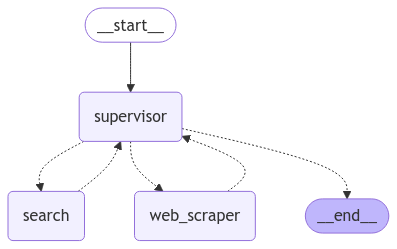

In [8]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

### g. Sample search work allocation

In [11]:
for s in research_graph.stream(
    {"messages": [("user", "when is Chelsea's's next football match?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content="Chelsea's next football match is against Brighton on Saturday at 12:00 PM. You can find more details about their upcoming fixtures [here](https://www.foxsports.com/soccer/chelsea-team-schedule).", additional_kwargs={}, response_metadata={}, name='search', id='97be2b8f-eed2-4471-82e7-b345e0d5dcc7')]}}
---
{'supervisor': {'next': '__end__'}}
---


### h. Define Agent teams - Document Writing Team

1. Import necessary dependencies

2. LLM Initialization

a. Creates an instance of ChatOpenAI using the "gpt-4o-mini" model. This is the LLM that will power all the agents.

3. Document Writer Agent and Node

a. Creates a doc_writer_agent with access to write_document, edit_document, and read_document tools. Its prompt instructs it to work based on outlines provided by the note-taker.

b. doc_writing_node is the function that defines how this agent interacts within the workflow. It invokes the agent, adds its response (wrapped in a HumanMessage) to the message history, and then directs the workflow back to the supervisor.

4. Note Taking Agent and Node

a. Creates a note_taking_agent with access to create_outline and read_document tools. Its prompt tells it to create outlines.

b. note_taking_node handles the agent's interaction in the workflow, similar to doc_writing_node.

5. Chart Generating Agent and Node

a. Creates a chart_generating_agent with access to read_document and python_repl_tool.

b. chart_generating_node handles its interaction in the workflow.

6. Supervisor Node

a. Creates the supervisor node using the make_supervisor_node function (defined in a previous code snippet). This supervisor will manage the three agents defined above.

Summary : This code defines a workflow with a supervisor and three worker agents: a document writer, a note taker, and a chart generator. The supervisor will determine which agent to call based on the overall task and the conversation history.  Each agent is specialized with specific tools and prompts to perform its role.  The *_node functions manage the agent's execution and ensure control returns to the supervisor after each agent's turn.  This structure enables a multi-agent system where different agents can collaborate to achieve a complex goal.

In [12]:
llm = ChatOpenAI(model="gpt-4o-mini")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

### i. Create Graph and visualize with the Writing team

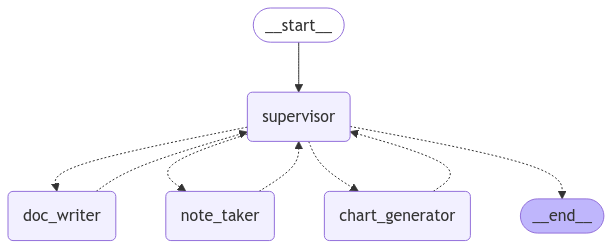

In [13]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

### j. Sample writing work allocation

In [14]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about AI and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The outline for the poem about AI has been created and saved as "ai_poem_outline.txt". The poem itself has also been written and saved as "ai_poem.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='238c2dca-a5f1-467d-9bb7-e5dcf51a4b90')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about AI has been created and saved as "ai_poem_outline.txt". The poem itself has also been written and saved as "ai_poem.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='34f1638c-9f6c-4ccb-b20f-615519980136')]}}
---
{'supervisor': {'next': 'chart_generator'}}
---
{'chart_generator': {'messages': [HumanMessage(content='Here is the outline for the poem about AI:\n\n### Outline for Poem about AI\n1. Introduction to AI\n2. The capabilities of AI\n3. AI and human interaction\n4. The ethical i

### K. Orchestrate the complete team from top

1. Import necessary dependencies

2. LLM Initialization

a. Creates an instance of ChatOpenAI using the "gpt-4o-mini" model

3. Teams Supervisor Node

a. Creates a supervisor node using make_supervisor_node. This supervisor will manage two teams: "research_team" and "writing_team".

4. Research Team Node

a. This function defines the "research_team" node.

b. Key Difference: Instead of invoking a single agent, it invokes an entire graph called research_graph using research_graph.invoke(). This implies that the research team's work is itself a complex workflow handled by a separate LangChain graph.

c. It passes the last message from the current state to the research_graph as input.

d. The response from the research_graph is then added as a HumanMessage (named "research_team") to the message history, and the workflow returns to the supervisor.

5. Paper Writing Team Node

This function defines the "writing_team" node. It's structured almost identically to call_research_team:

a. It invokes a separate graph called paper_writing_graph.

b. It adds the response from paper_writing_graph (wrapped in a HumanMessage named "writing_team") to the message history.

c. It returns control to the supervisor.

Key Idea : Nested Workflow

The crucial concept here is that research_graph and paper_writing_graph are themselves LangChain workflows (defined elsewhere in your code). This allows you to encapsulate complex logic within each team. The main workflow then becomes a higher-level orchestration, deciding which team to activate, but not needing to know the internal details of how each team does its work.

Summary

This code defines a high-level workflow with a supervisor and two team nodes. Each team node, instead of directly using agents, invokes a separate, nested LangChain graph. This structure promotes modularity and allows you to build complex, hierarchical workflows.  The supervisor manages the overall process, while the individual team graphs handle the specific tasks assigned to them.


In [15]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o-mini")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )

### l. Design and visualize the complete Hierarchical Team

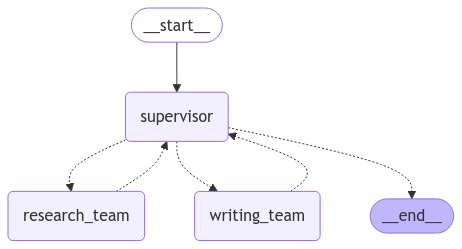

In [16]:
# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

### j. Invoke the complete hierarchical team

In [17]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research RAG based system and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='### Brief Report on Retrieval-Augmented Generation (RAG) Systems\n\n**Introduction**\nRetrieval-Augmented Generation (RAG) is a novel technique in artificial intelligence and natural language processing (NLP) designed to enhance the capabilities of generative AI models. By integrating large pre-trained language models (LLMs) with external information sources, RAG systems can generate responses that are coherent and grounded in relevant, real-time data.\n\n**How RAG Works**\nRAG systems connect generative AI models to external databases or knowledge repositories. The operation typically involves several stages:\n\n1. **Data Collection**: Aggregating information from sources such as internal databases, scholarly articles, or industry-specific datasets.\n2. **Data Chunking**: Dividing this data into manageable pieces for efficient retrieval.\n3. **Document Embeddings**: Creating vector repr

In [18]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research on India's GDP and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="### Report on India's GDP (2023)\n\n#### Overview\nAs of 2023, India's Gross Domestic Product (GDP) is approximately **$3.55 trillion**, making it one of the largest economies globally, accounting for around **3.37%** of the world economy. India ranks third among the largest economies, following the United States and China. The nation has witnessed significant economic evolution, emerging as a global player in diverse sectors.\n\n#### GDP Growth\n- The GDP growth rate for the fiscal year 2023-24 stands at **9.9%** in nominal terms for the fourth quarter.\n- Year-on-year growth rates have recorded **5.4%** in the second quarter for the fiscal year 2024-25, compared to **8.1%** during the same quarter of the previous year. This indicates a response to internal and external economic factors, including recovery from the COVID-19 pandemic and ongoing government policies to spur growth.\n\n###

In [21]:
print(f"Working Directory: {WORKING_DIRECTORY}")

Working Directory: /tmp/tmptz1uwh_b


In [22]:
!ls /tmp/tmptz1uwh_b

ai_poem_outline.txt  India_GDP_Outline_2023.txt  RAG_Report_Outline.txt
ai_poem.txt	     India_GDP_Report_2023.txt	 RAG_Report.txt


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
drive_destination_folder = "/content/drive/MyDrive/LangChainReports"

In [25]:
import os
if not os.path.exists(drive_destination_folder):
    os.makedirs(drive_destination_folder)

In [26]:
!cp /tmp/tmptz1uwh_b/India_GDP_Outline_2023.txt $drive_destination_folder
!cp /tmp/tmptz1uwh_b/India_GDP_Report_2023.txt $drive_destination_folder

In [27]:
!cp /tmp/tmptz1uwh_b/RAG_Report_Outline.txt $drive_destination_folder
!cp /tmp/tmptz1uwh_b/RAG_Report_Outline.txt $drive_destination_folder

In [28]:
!cp /tmp/tmptz1uwh_b/RAG_Report.txt $drive_destination_folder
!cp /tmp/tmptz1uwh_b/RAG_Report.txt $drive_destination_folder

In [29]:
!cp /tmp/tmptz1uwh_b/ai_poem_outline.txt $drive_destination_folder
!cp /tmp/tmptz1uwh_b/ai_poem_outline.txt $drive_destination_folder

In [30]:
!cp /tmp/tmptz1uwh_b/ai_poem.txt $drive_destination_folder
!cp /tmp/tmptz1uwh_b/ai_poem.txt $drive_destination_folder